# APRENDIZAJE AUTOMÁTICO
# Práctica 3: Regresión Logística Binaria
### Autor: Jiménez Omeñaca, David
### NIP:   825068
### Fecha: 24/02/2025
---


## Configuración

In [1]:
%matplotlib inline
try:
  from google.colab import drive
  print("Trabajando en Colab")
  drive.mount('/content/drive')                # Monta tu google drive
  Path = '/content/drive/MyDrive/Aprendizaje/' # Directorio donde guardas los ficheros
except:
  print("Trabajando en local")
  Path = 'data/'                                    # Directorio donde guardas los ficheros

Trabajando en local


---
## 0. Visualización de datos

c:\Users\User\Desktop\Automatic-Learning\Lab-01\.env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


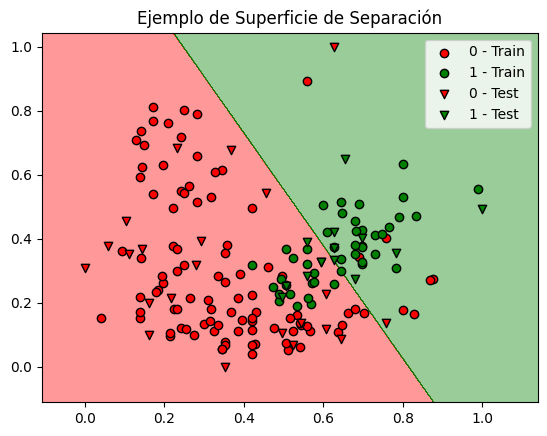

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

# Función para dibujar la superficie de separación de un clasificador con 2 clases y 2 atributos
def dibujar_clasificador(clf, X_train, y_train, X_test, y_test):
    colores = ListedColormap(["r", "g"])
    DecisionBoundaryDisplay.from_estimator(clf, X_train, eps = 0.15, cmap=colores, grid_resolution=1000, response_method="predict", alpha=0.4)
    plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c= "r", edgecolors="k", label='0 - Train')
    plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c= "g", edgecolors="k", label='1 - Train')
    plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1],  c= "r", marker = 'v', edgecolors="k", label='0 - Test')
    plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1],  c= "g", marker = 'v', edgecolors="k", label='1 - Test')
    plt.legend()

# Leer los ficheros de datos y pasarlos a matrices de numpy
data_train = pd.read_csv(Path+'wine_train.csv', sep = ";")
x1_train = data_train["f6"].to_numpy().reshape(-1, 1)
x2_train = data_train["f10"].to_numpy().reshape(-1, 1)
y_train  = data_train["Clase"].to_numpy()
X_train = np.c_[x1_train, x2_train]
y_train[y_train!=1]=0  # Transformar y en 0/1 Para clasificación binaria de la clase 1

data_test  = pd.read_csv(Path+'wine_test.csv',  sep = ";")
x1_test = data_test["f6"].to_numpy().reshape(-1, 1)
x2_test = data_test["f10"].to_numpy().reshape(-1, 1)
y_test  = data_test["Clase"].to_numpy()
X_test  = np.c_[x1_test, x2_test]
y_test[y_test!=1]=0   # Transformar y en 0/1 Para clasificación binaria de la clase 1

# Ejemplo de dibujar una superficie de separación
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(max_iter=1)
clf.fit(X_train, y_train)
dibujar_clasificador(clf, X_train, y_train, X_test, y_test)
plt.title("Ejemplo de Superficie de Separación")
plt.show()




Aquí explico las conclusiones que he sacado analizando los datos.

---
## 0. Setup

Comenzamos creando las clases necesarias para representar modelos

In [3]:
from enum import IntFlag
from typing import Dict
import pandas as pd

class Models:
    """
    A class to represent a collection of models and their computed metrics.

    This class is used to store, append, sort, and display metrics computed for multiple models.
    """
    
    def __init__(self):
        """
        Initializes an empty DataFrame to store model metrics.
        """
        self.df = pd.DataFrame()
    
    def append(self, model: pd.DataFrame):
        """
        Appends a new model's metrics to the collection.

        Parameters
        ----------

        model (pd.DataFrame) : A DataFrame containing the metrics of a single model.
        """
        self.df = pd.concat([self.df, model], axis=0, ignore_index=True)
    
    def sort(self, by: str, ascending: bool = True):
        """
        Sorts the stored models by a specified column.

        Parameters
        ----------

        by (str) : The column name by which to sort the models.
        ascending (bool, optional) : Whether to sort in ascending order. Defaults to True.
        """
        self.df = self.df.sort_values(axis=0, ascending=ascending, by=by)
    
    def print(self) -> pd.DataFrame:
        """
        Returns the stored DataFrame of model metrics.

        Returns
        -------

        pd.DataFrame : The DataFrame containing all appended model metrics.
        """
        return self.df


class ClassificationMetricsFlags(IntFlag):
    """
    Class to represent which error metrics to compute in a Linear Regression 
    analysis.

    It supports:

    - **RMSE**: Root Mean Squared Error 
    - **MAE**: Mean Absolute Error
    - **MedAE**: Median Absolute Error
    - **MRE**: Mean Relative Error
    - **MedRE**: Median Relative Error
    - **R2**: Coefficient of Determination (R^2)
    """

    PRECISSION = 1 << 0
    RECALL = 1 << 1
    F1 = 1 << 2
    ACCURACY = 1 << 3
    BALANCED_ACCURACY = 1 << 4
    FBEETA = 1 << 5


class ClassificationMetrics():

    def __init__(self, y_real, y_pred, flags):
        self.y_real = y_real
        self.y_pred = y_pred
        self.flags = flags
    
    def Precission(self):
        TP = np.sum((self.y_real == 1) & (self.y_pred == 1))
        FP = np.sum((self.y_real == 0) & (self.y_pred == 1))
        return TP / (TP + FP) if TP + FP > 0 else 1

    def Recall(self):
        TP = np.sum((self.y_real == 1) & (self.y_pred == 1))
        FN = np.sum((self.y_real == 1) & (self.y_pred == 0))
        return TP / (TP + FN) 
    
    def F1(self):
        precission = self.Precission()
        recall = self.Recall()
        return 2 * (precission * recall) / (precission + recall)
    
    def Accuracy(self):
        TP = np.sum((self.y_real == 1) & (self.y_pred == 1))
        TN = np.sum((self.y_real == 0) & (self.y_pred == 0))
        return (TP + TN) / len(self.y_real)
    
    def BalancedAccuracy(self):
        TP = np.sum((self.y_real == 1) & (self.y_pred == 1))
        TN = np.sum((self.y_real == 0) & (self.y_pred == 0))
        FP = np.sum((self.y_real == 0) & (self.y_pred == 1))
        FN = np.sum((self.y_real == 1) & (self.y_pred == 0))
        return (TP / (TP + FN) + TN / (TN + FP)) / 2
    
    def FBeta(self, beta):
        precission = self.Precission()
        recall = self.Recall()
        return (1 + beta**2) * (precission * recall) / (beta**2 * precission + recall)
    
    def compute_metrics(self, name:str, r:int, beta:0.5) -> Dict[str, float]:
        metrics = {
            f'prec_{name}': [round(self.Precission(), r)] if self.flags & ClassificationMetricsFlags.PRECISSION else [],
            f'recall_{name}': [round(self.Recall(), r)] if self.flags & ClassificationMetricsFlags.RECALL else [],
            f'f1_{name}': [round(self.F1(), r)] if self.flags & ClassificationMetricsFlags.F1 else [],
            f'acc_{name}': [round(self.Accuracy(), r)] if self.flags & ClassificationMetricsFlags.ACCURACY else [],
            f'bal_acc_{name}': [round(self.BalancedAccuracy(), r)] if self.flags & ClassificationMetricsFlags.BALANCED_ACCURACY else [],
            f'fbeta_{name}': [round(self.FBeta(beta), r)] if self.flags & ClassificationMetricsFlags.FBEETA else []
        }
        return metrics

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
i = 0
class LogisticModel():
    def __init__(self, x_train, y_train, x_test, y_test, model, metrics, name):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.model = model
        self.metrics = metrics
        self.name = name

        self.model.fit(self.x_train, self.y_train)
    
    def plot_decision_boundary(self, title:str="Superficie de Separación"):
        dibujar_clasificador(self.model, self.x_train, self.y_train, self.x_test, self.y_test)
        plt.title(title)
        plt.show()
    
    def compute_metrics(self, r=2):
        y_pred_train = self.model.predict(self.x_train)
        y_pred_test = self.model.predict(self.x_test)
        train_metrics = ClassificationMetrics(self.y_train, y_pred_train, self.metrics)
        train_metrics = train_metrics.compute_metrics("train", r, 0.5)

        test_metrics = ClassificationMetrics(self.y_test, y_pred_test, self.metrics)
        test_metrics = test_metrics.compute_metrics("test", r, 0.5)

        metrics = {"Name": self.name, **train_metrics, **test_metrics}
        metrics = {a:b for (a,b) in metrics.items() if b}

        return pd.DataFrame(metrics)
    
    def plot_confusion_matrix(self):
        from sklearn.metrics import plot_confusion_matrix
        plot_confusion_matrix(self.model, self.x_test, self.y_test)
        plt.show()

    def plot_prec_rec_curve(self, title:str=""):
        from sklearn.metrics import precision_recall_curve
        global i, colors
        prec, rec, thresholds = precision_recall_curve(self.y_test, self.model.predict_proba(self.x_test)[:,1])
        max_v = max([(x,y,z) for (x,y,z) in zip(prec, rec, thresholds) if x >= 0.9], key=lambda x: x[1])
        plt.plot(max_v[1], max_v[0], marker='x', markersize=10, color=colors[i])
        plt.plot(rec, prec, marker='.', label=self.name, color=colors[i])
        i+=1
        plt.xlabel("Recall")
        plt.ylabel("Precission")
        return max_v
    
    def compute_metrics_threshold(self, threshold, r=2):
        y_pred_train = self.model.predict_proba(self.x_train)[:,1] > threshold
        y_pred_test = self.model.predict_proba(self.x_test)[:,1] > threshold

        train_metrics = ClassificationMetrics(self.y_train, y_pred_train, self.metrics)
        train_metrics = train_metrics.compute_metrics("train", r, 0.5)

        test_metrics = ClassificationMetrics(self.y_test, y_pred_test, self.metrics)
        test_metrics = test_metrics.compute_metrics("test", r, 0.5)

        metrics = {"Name": self.name, **train_metrics, **test_metrics}
        metrics = {a:b for (a,b) in metrics.items() if b}

        return pd.DataFrame(metrics)

    def k_fold_cross_validation(self, param_name, param_range, title="", k=5):
        from sklearn.model_selection import GridSearchCV
        parameter_grid = {param_name: param_range}
        grid = GridSearchCV(self.model, parameter_grid, cv=k, scoring='f1', return_train_score=True, n_jobs=-1)
        grid.fit(self.x_train, self.y_train)
        grid_train_errors = grid.cv_results_['mean_train_score']
        grid_test_errors = grid.cv_results_['mean_test_score']

        plt.plot(param_range, grid_train_errors, label='Train')
        plt.plot(param_range, grid_test_errors, label='Validation')
        plt.xscale('log')
        plt.legend()
        plt.title(title)
        plt.show()

        return (grid.best_params_, grid.best_estimator_)
       

## 1. Métricas elegidas

Para la práctica, se han elegido las métricas: **Precisión**, **Recall**, **Accuracy**, **F1** y **Accuracy Balanceada**.

In [4]:
flags = ClassificationMetricsFlags.PRECISSION | ClassificationMetricsFlags.RECALL | ClassificationMetricsFlags.F1 | ClassificationMetricsFlags.ACCURACY | ClassificationMetricsFlags.BALANCED_ACCURACY

models = Models()

## 2.Regresión logística Básica

Ahora vamos a ajustar un modelo de regresión logística básico. Ploteamos la superficie de separación

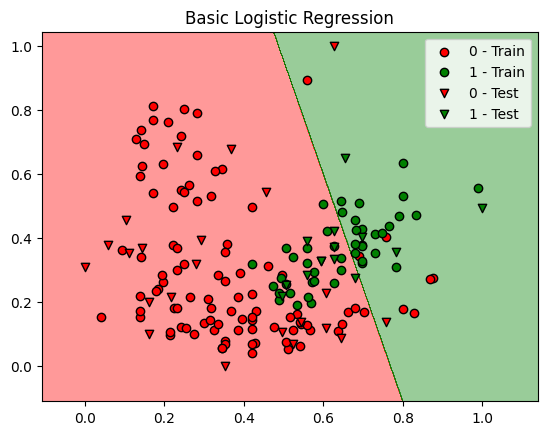

In [5]:
from sklearn.linear_model import LogisticRegression

model_1 = LogisticModel(X_train, y_train, X_test, y_test, LogisticRegression(), flags, "Basic Logistic Regression")

model_1.plot_decision_boundary("Basic Logistic Regression")

y calculamos las métricas

In [6]:
model_1.compute_metrics()

models.append(model_1.compute_metrics())

donde podemos ver un bajo valor *F1* indicando que el modelo no es adecuado.

Ahora vamos a plotear una línea de la probabilidad de pertenecer a la clase 1 dejando el atributo 6 igual a $0.6$ y variando el atributo 10 de $0$ a $1$.

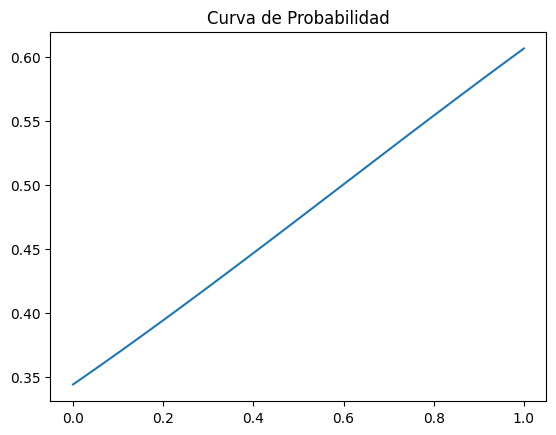

In [7]:
x_curve = np.column_stack((np.repeat(0.6,100),np.linspace(0, 1, 100)))

y_curve = model_1.model.predict_proba(x_curve)[:,1]

plt.plot(x_curve[:,1], y_curve, label="Probabilidad")
plt.title("Curva de Probabilidad")
plt.show()

Aquí se puede ver una tendencia lineal entre el atributo 10 y la probabilidad de ser de clase 1, siempre que el atributo 6 sea igual a 0.1.


## 3. Expansión de atributos

Ahora vamos a ajustar el mismo modelo con un polinomio de grado $6$ sin regularizar. Probamos con dos solvers: `liblinear` y `lbdfg`, ya que tenemos un pequeño dataset ( como se indica en [Scikit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html))

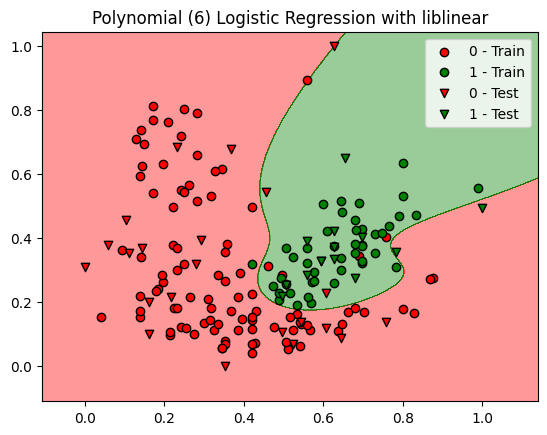

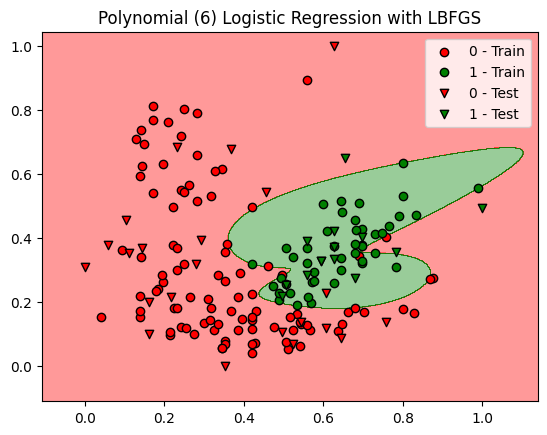

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

_mod_2_1 = make_pipeline(PolynomialFeatures(6), LogisticRegression(solver='liblinear', tol=1e-6, C=1e7))
_mod_2_2 = make_pipeline(PolynomialFeatures(6), LogisticRegression(solver='lbfgs', penalty=None, tol=1e-6, max_iter=10000))

model_2_adam = LogisticModel(X_train, y_train, X_test, y_test, _mod_2_1, flags, "Polynomial (6) Logistic liblinear")
model_2_lbfgs = LogisticModel(X_train, y_train, X_test, y_test, _mod_2_2, flags, "Polynomial (6) Logistic LBFGS")

model_2_adam.plot_decision_boundary("Polynomial (6) Logistic Regression with liblinear")
model_2_lbfgs.plot_decision_boundary("Polynomial (6) Logistic Regression with LBFGS")

models.append(model_1.compute_metrics())
models.append(model_2_adam.compute_metrics())

y las métricas:

In [9]:
pd.concat([model_2_lbfgs.compute_metrics(), model_2_adam.compute_metrics()])

,Name,prec_train,recall_train,f1_train,acc_train,bal_acc_train,prec_test,recall_test,f1_test,acc_test,bal_acc_test
0,Polynomial (6) Logistic LBFGS,0.96,0.98,0.97,0.98,0.98,0.92,0.79,0.85,0.89,0.87
0,Polynomial (6) Logistic liblinear,0.92,0.98,0.95,0.96,0.97,0.86,0.86,0.86,0.89,0.88


Aquí se puede ver que, a pesar de estar obteniendo buenos resultados en los datos de training, en los datos de test las métricas son peores. Esto se debe a que la zona de decisión se está sobreajustando a los datos de test con formas muy concretas para englobar casi todos.

## 4. Regresión Polinómica Regularizada

Ahora vamos a realizar el mismo ajuste añadiendo regularización para controlar el sobre-ajuste del modelo. Para ello, vamos a elegirlo a través de `K-Fold Validation`. Vamos a realizarlo para dos solvers diferentes: `liblinear` y `lbfgs`.

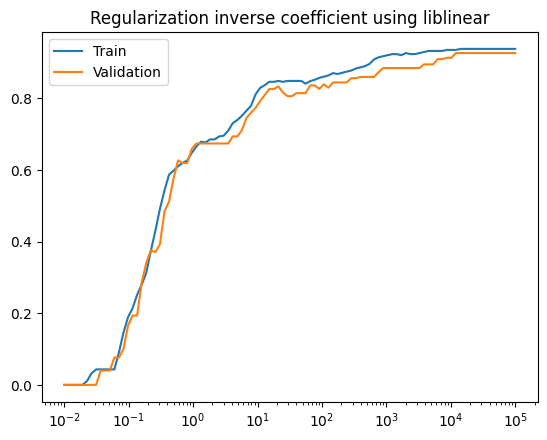

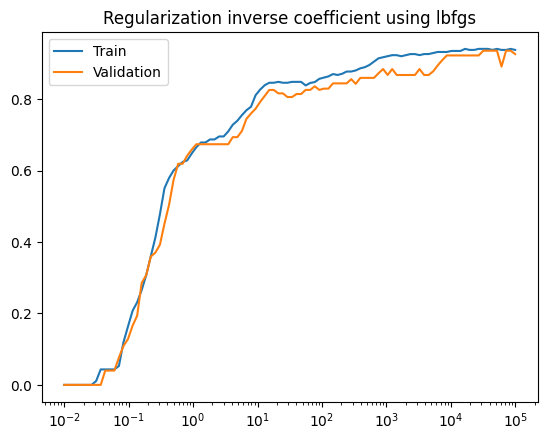

In [10]:
_mod_3_liblinear = make_pipeline(PolynomialFeatures(6), LogisticRegression(solver='liblinear'))
_mod_3_lbfsg = make_pipeline(PolynomialFeatures(6), LogisticRegression(solver='lbfgs'))

model_3_ll = LogisticModel(X_train, y_train, X_test, y_test, _mod_3_liblinear, flags, "Polynomial (6) Logistic Regression Liblinear")
model_3_lbfgs = LogisticModel(X_train, y_train, X_test, y_test, _mod_3_lbfsg, flags, "Polynomial (6) Logistic Regression LBFGS")

(best_value_ll, best_model_ll) = model_3_ll.k_fold_cross_validation('logisticregression__C', np.logspace(-2, 5, 100), title="Regularization inverse coefficient using liblinear", k=5)
(best_value_lbfgs, best_model_lbfgs) = model_3_lbfgs.k_fold_cross_validation('logisticregression__C', np.logspace(-2, 5, 100), title="Regularization inverse coefficient using lbfgs", k=5)

Así, el mejor modelo tiene un hiperparámetro $C = \frac{1}{\lambda}$ óptimo de:

In [11]:
print("Best C LibLinear: ", float(best_value_ll['logisticregression__C']))
print("Best C LBFGS: ", float(best_value_lbfgs['logisticregression__C']))

Best C LibLinear:  12045.035402587811
Best C LBFGS:  31992.671377973846


Calculamos las métricas para este mejor modelo y lo añadimos al modelo con este hiperparámetro:

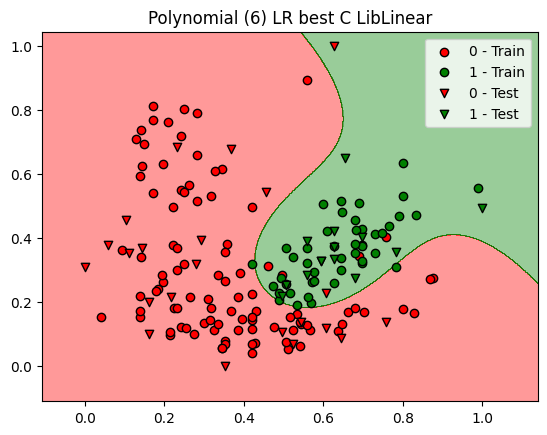

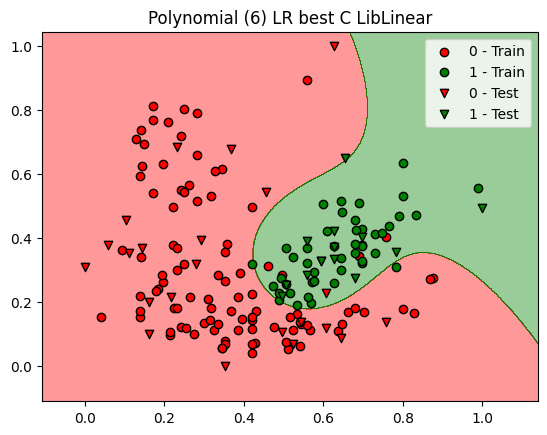

In [18]:
model_3_ll = LogisticModel(X_train, y_train, X_test, y_test, best_model_ll, flags, "Polynomial (6) LR best C LibLinear")
model_3_lbfgs = LogisticModel(X_train, y_train, X_test, y_test, best_model_lbfgs, flags, "Polynomial (6) LR best C LibLinear")

models.append(model_3_ll.compute_metrics())
models.append(model_3_lbfgs.compute_metrics())

model_3_ll.plot_decision_boundary("Polynomial (6) LR best C LibLinear")
model_3_lbfgs.plot_decision_boundary("Polynomial (6) LR best C LibLinear")

In [13]:
pd.concat([model_3_lbfgs.compute_metrics(), model_3_ll.compute_metrics()])

,Name,prec_train,recall_train,f1_train,acc_train,bal_acc_train,prec_test,recall_test,f1_test,acc_test,bal_acc_test
0,Polynomial (6) LR best C LibLinear,0.91,0.96,0.93,0.96,0.96,0.93,0.93,0.93,0.94,0.94
0,Polynomial (6) LR best C LibLinear,0.91,0.96,0.93,0.96,0.96,0.88,1.00,0.93,0.94,0.95


Se puede ver que ambos modelos han ajustado casi idénticamente los datos, obteniendo unos resultados bastante buenos tanto en test como en training. Esto nos permite concluir que se ha controlado el sobreajuste.

## Curvas Precisión-Recall

Ahora vamos a imprimir las gráficas de precisión y recall para cada uno de los modelos:

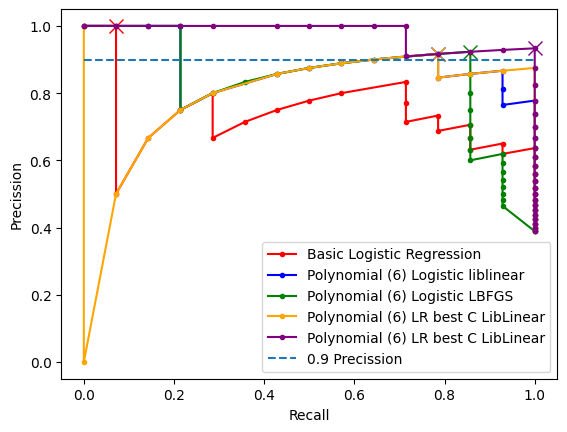

In [14]:
i=0
models_ = [model_1, model_2_adam, model_2_lbfgs, model_3_ll, model_3_lbfgs]
thresholds_ = []

for model in models_:
    thresholds_.append((model.name, model.plot_prec_rec_curve(model.name)))
    

plt.plot(np.linspace(0,1,100), np.repeat(0.9,100),label="0.9 Precission", linestyle='--')
plt.legend()
plt.show()

Además de calcular la curva precisión-recall, también se ha calculado el mejor threshold de cada modelo que asegura un $90\%$ de precisión, es decir, el threshold que da un mejor recall de los que tienen al menos un $90\%$ de precisión. 

Sabemos que este punto existe para todo modelo ya que si el threshold es $\delta = 0$, tenemos precisión del $100\%$.



Se han ploteado como cruces en el gráfico y se exponen a continuación.

In [15]:
dic = {"Models":[], "Threshold": [], "Precission": [], "Recall": []}
for threshold in thresholds_:
    dic["Models"].append(threshold[0])
    dic["Threshold"].append(threshold[1][2])
    dic["Precission"].append(threshold[1][0])
    dic["Recall"].append(threshold[1][1])

pd.DataFrame(dic).sort_values(by="Recall", ascending=False)

,Models,Threshold,Precission,Recall
4,Polynomial (6) LR best C LibLinear,0.436850,0.933333,1.000000
2,Polynomial (6) Logistic LBFGS,0.024131,0.923077,0.857143
1,Polynomial (6) Logistic liblinear,0.928615,0.916667,0.785714
3,Polynomial (6) LR best C LibLinear,0.832140,0.916667,0.785714
0,Basic Logistic Regression,0.804298,1.000000,0.071429


Ajustamos estos modelos y los añadimos a unos nuevos modelos:

In [16]:
df = pd.concat([models_[i].compute_metrics_threshold(thresholds_[i][1][2]) for i in range(len(models_))])
df.sort_values(by="f1_test", ascending=False)

,Name,prec_train,recall_train,f1_train,acc_train,bal_acc_train,prec_test,recall_test,f1_test,acc_test,bal_acc_test
0,Polynomial (6) LR best C LibLinear,0.92,0.98,0.95,0.96,0.97,0.93,0.93,0.93,0.94,0.94
0,Polynomial (6) Logistic LBFGS,0.88,1.00,0.94,0.96,0.97,0.92,0.79,0.85,0.89,0.87
0,Polynomial (6) Logistic liblinear,1.00,0.60,0.75,0.87,0.80,0.91,0.71,0.80,0.86,0.83
0,Polynomial (6) LR best C LibLinear,0.92,0.80,0.86,0.92,0.88,0.91,0.71,0.80,0.86,0.83
0,Basic Logistic Regression,1.00,0.02,0.04,0.69,0.51,1.00,0.00,0.00,0.61,0.50


que comparados con los normales:

In [20]:
models.sort("f1_test", ascending=False)
models.print()

,Name,prec_train,recall_train,f1_train,acc_train,bal_acc_train,prec_test,recall_test,f1_test,acc_test,bal_acc_test
4,Polynomial (6) LR best C LibLinear,0.91,0.96,0.93,0.96,0.96,0.93,0.93,0.93,0.94,0.94
3,Polynomial (6) LR best C LibLinear,0.91,0.96,0.93,0.96,0.96,0.88,1.00,0.93,0.94,0.95
2,Polynomial (6) Logistic liblinear,0.92,0.98,0.95,0.96,0.97,0.86,0.86,0.86,0.89,0.88
0,Basic Logistic Regression,0.76,0.49,0.59,0.79,0.71,0.67,0.29,0.40,0.67,0.60
1,Basic Logistic Regression,0.76,0.49,0.59,0.79,0.71,0.67,0.29,0.40,0.67,0.60


Al imponer la restricción de precisión al $90\%$, algunos modelos como el de regresión logística básico, han sido incapaces de suministrar un buen resultado con un recall decente. Sin embargo, otros como es el caso de la regresión logística utilizando LibLinear regularizado, han sido capaces de poder asegurar esta precisión sin comprometer el valor del recall. Esto nos está indicando que son modelos muy robustos, que son capaces de precedir bastante bien la pertenencia o no a la clase 1.